# 前置

In [ ]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
import kagglehub
import os
!pip install kagglehub

In [ ]:
kagglehub.dataset_download("brendanartley/cartoon-faces-googles-cartoon-set")

Using Colab cache for faster access to the 'cartoon-faces-googles-cartoon-set' dataset.


'/kaggle/input/cartoon-faces-googles-cartoon-set'

In [ ]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
encoder = keras.models.load_model(
    'encoder_30.keras',
    custom_objects={'Sampling': Sampling}
)
decoder = keras.models.load_model('decoder_30.keras')

IMG_SIZE = 96
BATCH_SIZE = 128

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    img = img.astype('float32') / 255.0
    return img

In [ ]:
IMG_SIZE = 96
BATCH_SIZE = 128


def preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img

def get_average_z(image_paths):

    ds = tf.data.Dataset.from_tensor_slices(image_paths)
    ds = ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)

    z_sum = None
    count = 0

    for batch in ds:
        outputs = encoder.predict(batch, verbose=0)
        z_mean_batch = outputs[0]

        if z_sum is None:
            z_sum = np.sum(z_mean_batch, axis=0)
        else:
            z_sum += np.sum(z_mean_batch, axis=0)

        count += len(batch)
    z_avg = z_sum / count
    return z_avg

# find z vector dir

In [ ]:
CSV_PATH = '/content/glasses-2.csv'
PATH_COL = 'filepath'
LABEL_COL = 'label'

df = pd.read_csv(CSV_PATH)

boy_paths = df[df[LABEL_COL] == 1][PATH_COL].values
girl_paths = df[df[LABEL_COL] == 0][PATH_COL].values

z_boy_mean = get_average_z(boy_paths)
z_girl_mean = get_average_z(girl_paths)

vector_dir = z_boy_mean - z_girl_mean

In [ ]:
np.save('glasses_vector.npy', vector_dir)

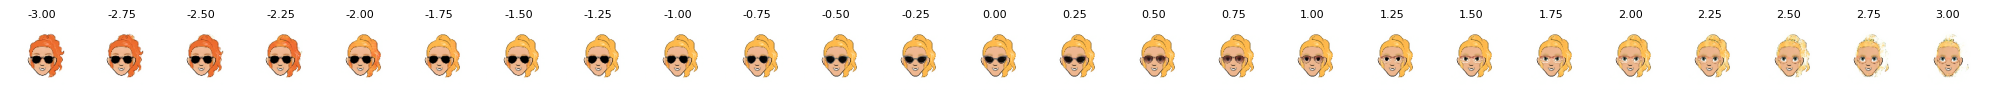

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

n_steps = 25
scale_min = -3
scale_max = 3


start_img_path = random.choice(boy_paths)

original_img = preprocess_image(start_img_path)
original_img_batch = tf.expand_dims(original_img, 0)
z_start, _, _ = encoder.predict(original_img_batch, verbose=0)

alphas = np.linspace(scale_min, scale_max, n_steps)

plt.figure(figsize=(20, 10))

for i, alpha in enumerate(alphas):
    z_new = z_start - (alpha * vector_dir)

    generated_img = decoder.predict(z_new, verbose=0);

    ax = plt.subplot(1, n_steps, i + 1)
    plt.imshow(generated_img[0])
    plt.axis('off')

    ax.set_title(f"{alpha:.2f}", fontsize=8)


plt.tight_layout()
plt.show()

# test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

LATENT_DIM = 128


vectors = {}

vectors['Gender (Boy/Girl)'] = np.load('gender_vector.npy')
vectors['glasses (1/0)'] = np.load('glasses_vector.npy')
vectors['skin color(1/0)'] = np.load('skincolor_vector.npy')

available_attrs = list(vectors.keys())

In [ ]:
current_z_base = np.random.normal(0, 1, size=(1, LATENT_DIM))

def update_image(change=None):
    global current_z_base

    z_new = current_z_base.copy()

    for attr_name, slider in slider_ui.items():
        val = slider.value
        if attr_name in vectors:
            z_new += val * vectors[attr_name]

    gen_img = decoder.predict(z_new, verbose=0);

    plt.figure(figsize=(4, 4))
    plt.imshow(gen_img[0])
    plt.axis('off')
    plt.title("Generated Result")
    plt.show()

def on_random_click(b):
    global current_z_base
    current_z_base = np.random.normal(0, 1, size=(1, LATENT_DIM))

    for slider in slider_ui.values():
        slider.value = 0.0

    output_area.clear_output(wait=True)
    with output_area:
        update_image()

btn_random = widgets.Button(
    button_style='info',
    icon='random'
)
btn_random.on_click(on_random_click)

slider_ui = {}
for attr in available_attrs:
    slider_ui[attr] = widgets.FloatSlider(
        min=-3.0, max=3.0, step=0.1, value=0.0,
        description=attr,
        continuous_update=False
    )
    slider_ui[attr].observe(lambda change: output_area.clear_output(wait=True) or output_area.append_stdout('') or  with_output_update(), names='value')

output_area = widgets.Output()

def with_output_update():
    with output_area:
        update_image()

for slider in slider_ui.values():
    slider.observe(lambda change: with_output_update(), names='value')


print("控制面板：")
display(btn_random)
for slider in slider_ui.values():
    display(slider)

print("\n生成結果：")
display(output_area)

with_output_update()

控制面板：


Button(button_style='info', description='隨機生成一張 (Random)', icon='random', style=ButtonStyle())

FloatSlider(value=0.0, continuous_update=False, description='Gender (Boy/Girl)', max=3.0, min=-3.0)

FloatSlider(value=0.0, continuous_update=False, description='glasses (1/0)', max=3.0, min=-3.0)

FloatSlider(value=0.0, continuous_update=False, description='skin color(1/0)', max=3.0, min=-3.0)


生成結果：


Output()